<h1>Transfer Learning and Fine-tuning</h1>

We're going to build a model for classification of images of cats and dogs using transfer learning from a pre-trained neural network.

A pre-trained model is a neural network that has been previously trained in a large set of data. Then we can customize this model to another specific task.

The general idea behind the transfer learning tecnique is that a model which has been trained in a fairly large dataset can be used as a generic model of the world. So these learned features can be used as a starting point for other datasets.

Two main approaches for customizing a pre-trained model:
<ol>
<li>Feature extraction: Using features from another neural network to apply them to new instances. A brand new classifier is trained upon the pre-trained model, particularly the convolutional layers.</li>
<li>Fine-tuning: Unfreezing the upper layers from a model and training the final layers along with new layers to yield relevant feature representations for a specific task.</li>
</ol>

<ol>
General Workflow
<li>Examining and understading the data</li>
<li>Build a data pipeline using Keras' ImageDataGenerator</li>
<li>Build a model
<ul>Load the pre-trained model and its weights</ul>
<ul>Stack classification layers on top</ul></li>
<li>Train the model</li>
<li>Evaluate</li></ol>

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

<h2>Data preprocessing</h2>
<h3>Downloading data</h3>

After downloading the cat and dogs dataset, a `tf.data.Dataset` will be created for training and validation, using `tf.keras.preprocessing.image_dataset_from_directory`.

If the directory has this structure:

    main_directory/
    ...class_a/
    ......a_image_1.jpg
    ......a_image_2.jpg
    ...class_b/
    ......b_image_1.jpg
    ......b_image_2.jpg

Then calling `image_dataset_from_directory(main_directory, labels='inferred')` will return a `tf.data.Dataset` that yields batches of images from the subdirectories `class_a` and `class_b`, together with labels 0 and 1 (0 corresponding to class_a and 1 corresponding to class_b).

In [4]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
pathZip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(pathZip), 'cats_and_dogs_filtered')

trainDir = os.path.join(PATH, 'train')
validationDir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

trainDataset = image_dataset_from_directory(trainDir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

68608000/68606236 [==============================] - 5s 0us/step
Found 2000 files belonging to 2 classes.


In [5]:
validationDataset = image_dataset_from_directory(validationDir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


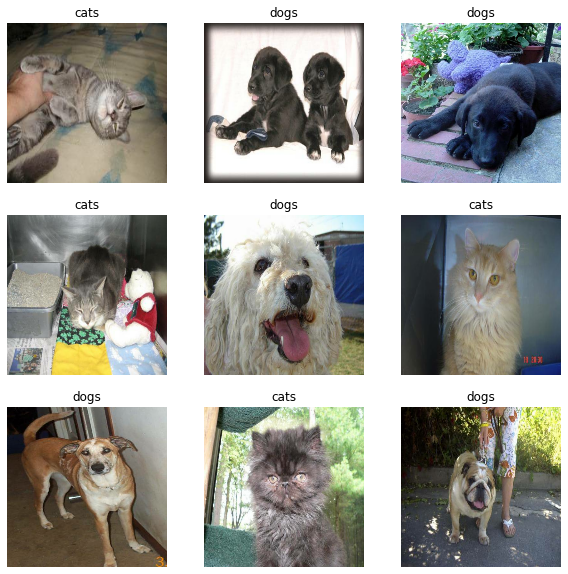

In [7]:
#Displays nine images and labels from training set
classNames = trainDataset.class_names

plt.figure(figsize=(10,10))
for imgs, lbls in trainDataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(imgs[i].numpy().astype("uint8"))
        plt.title(classNames[lbls[i]])
        plt.axis("off")

`tf.data.experimental.cardinality` determines how many batches of data are available in the validation set. 20% will be moved to a test set.

In [11]:
valBatches = tf.data.experimental.cardinality(validationDataset)
testDataset = validationDataset.take(valBatches // 5)
validationDataset = validationDataset.skip(valBatches // 5)

In [12]:
print(f'Number of validation batches {tf.data.experimental.cardinality(validationDataset)}')
print(f'Number of test batches {tf.data.experimental.cardinality(testDataset)}')

Number of validation batches 26
Number of test batches 6


The API `tf.data` helps building flexible and efficient input pipelines. To reach maximum performance we need an efficient input pipeline that sends data to the next stage before the current stage is finished.

In [13]:
autotune = tf.data.AUTOTUNE

trainDataset = trainDataset.prefetch(buffer_size=autotune)
validationDataset = validationDataset.prefetch(buffer_size=autotune)
testDataset = testDataset.prefetch(buffer_size=autotune)

<h3>Using Data Augmentation</h3>

In [16]:
dataAugmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)])

<b>An example of image augmentation</b>

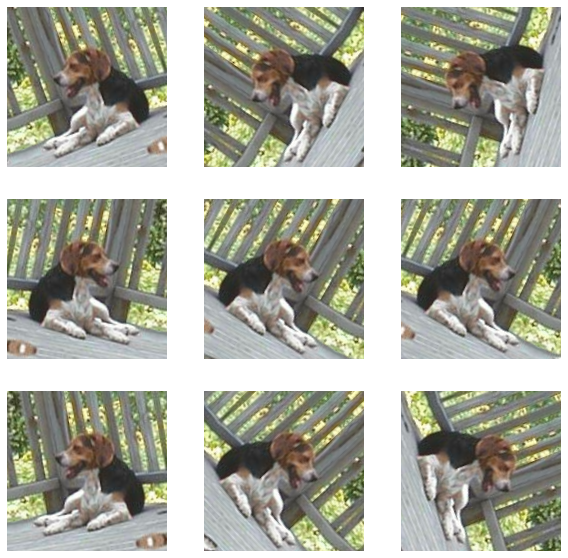

In [23]:
for img, _ in trainDataset.take(1):
    plt.figure(figsize=(10,10))
    firstImage = img[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        augmentedImage = dataAugmentation(tf.expand_dims(firstImage, 0))
        plt.imshow(augmentedImage[0]/255.)
        plt.axis('off')

<h2>Rescaling pixel values</h2>
According to the API documentation, the model `tf.keras.applications.MobileNetV2` expects pixel values between [-1, 1], but our current images are between [0, 255]. They can be rescaled using a preprocessing method from the model.

In [24]:
preprocessInput = tf.keras.applications.mobilenet_v2.preprocess_input

Another approach is to use `Rescaling`:
```
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)
```

For instance:
<ol>
<ul>To rescale an input in the [0, 255] range to be in the [0, 1] range, you would pass scale=1./255.</ul>

<ul>To rescale an input in the [0, 255] range to be in the [-1, 1] range, you would pass scale=1./127.5, offset=-1.</ul>
</ol>
The rescaling is applied both during training and inference.

<h1>Building a basic model from pre-trained convolutional networks</h1>
The basic model will be created from Google's MobileNet V2. This model was pre-trained in the ImageNet dataset, which has 1,4 million images and 1000 classes. This knowledge base will help in our cat-dog classification task.

First, we need to decide which layer from MobileNet V2 is going to be used for feature extraction. The bottleneck layer is considered more useful because it comes before the leveling operation. Its features are more general in relation to the last/final layer.

Upon loading the model, the argument `include_top = False` excludes the upper layers.

In [25]:
IMG_SHAPE = IMG_SIZE + (3, )

baseModel = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')

9412608/9406464 [==============================] - 1s 0us/step


The feature extractor converts each image `160x160x3` in a feature block `5x5x1280`.

In [26]:
imgBatch, lblBatch = next(iter(trainDataset))
featureBatch = baseModel(imgBatch)
print(featureBatch.shape)

(32, 5, 5, 1280)


<h2>Extracting Features</h2>
In this step, the base convnet is frozen to be used as a feature extractor. A classifier will be built on top of it and the upper level classifier will be trained.

<h3>Freezing the model</h3>
This should be done before compiling and training the model. Freezing (layer.trainable=False) excludes from training the weights from another layer.

Layers & models have three weight attributes:

`weights` is the list of all weights variables of the layer.

`trainable_weights` is the list of those that are meant to be updated (via gradient descent) to minimize the loss during training.

`non_trainable_weights` is the list of those that aren't meant to be trained. Typically they are updated by the model during the forward pass.

In [ ]:
baseModel.trainable = False

In [27]:
baseModel.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [28]:
globalAverageLayer = tf.keras.layers.GlobalAveragePooling2D()
featBatchAverage = globalAverageLayer(featureBatch)
print(featBatchAverage.shape)

(32, 1280)


In [29]:
predictionLayer = tf.keras.layers.Dense(1)

predictionBatch = predictionLayer(featBatchAverage)

print(predictionBatch.shape)

(32, 1)


Building a model in a chain of layers with data augmentation, rescaling, the base model and feature extractor, using Keras Functional API.

In [32]:
inputs = tf.keras.Input(shape=(160,160,3))

x = dataAugmentation(inputs)
x = preprocessInput(x)
x = baseModel(x, training=False)
x = globalAverageLayer(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = predictionLayer(x)

model = tf.keras.Model(inputs, outputs)

In [33]:
baseLearningRate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=baseLearningRate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [35]:
len(model.trainable_variables)

158

In [36]:
initialEpochs = 8

loss0, acc0 = model.evaluate(validationDataset)

26/26 [==============================] - 18s 595ms/step - loss: 0.7525 - accuracy: 0.5186


In [38]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(acc0))

initial loss: 0.75
initial accuracy: 0.52


In [39]:
history = model.fit(trainDataset,
                    epochs=initialEpochs,
                    validation_data=validationDataset )

Epoch 1/10
63/63 [==============================] - 169s 3s/step - loss: 0.2274 - accuracy: 0.8960 - val_loss: 0.0537 - val_accuracy: 0.9765
Epoch 2/10
63/63 [==============================] - 154s 2s/step - loss: 0.1561 - accuracy: 0.9310 - val_loss: 0.1191 - val_accuracy: 0.9579
Epoch 3/10
63/63 [==============================] - 153s 2s/step - loss: 0.1002 - accuracy: 0.9605 - val_loss: 0.0491 - val_accuracy: 0.9827
Epoch 4/10
63/63 [==============================] - 153s 2s/step - loss: 0.0883 - accuracy: 0.9670 - val_loss: 0.0394 - val_accuracy: 0.9814
Epoch 5/10
63/63 [==============================] - 153s 2s/step - loss: 0.0924 - accuracy: 0.9645 - val_loss: 0.0591 - val_accuracy: 0.9827
Epoch 6/10
63/63 [==============================] - 153s 2s/step - loss: 0.0754 - accuracy: 0.9715 - val_loss: 0.0504 - val_accuracy: 0.9790
Epoch 7/10
63/63 [==============================] - 154s 2s/step - loss: 0.0570 - accuracy: 0.9800 - val_loss: 0.0330 - val_accuracy: 0.9876
Epoch 8/10
63

<h2>Learning Curves</h2>

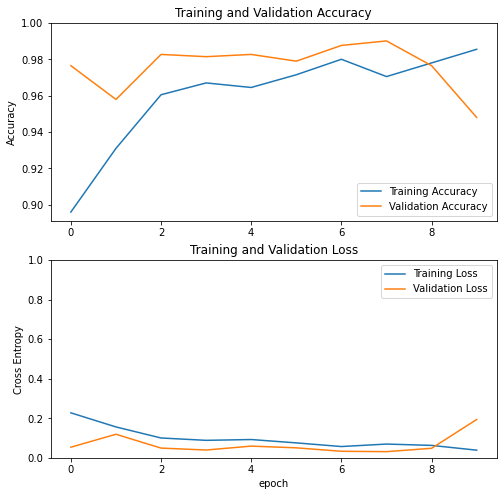

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

<h2>Fine Tuning</h2>

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

Un-freeze the top layers of the model

All you need to do is unfreeze the base_model and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.


In [41]:
baseModel.trainable = True

In [42]:
print(f'Number of layers in the base model: {len(baseModel.layers)}')

fineTune_at = 100

for layer in baseModel.layers[:fineTune_at]:
    layer.trainable = False

Number of layers in the base model: 154


In [45]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=baseLearningRate/10),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [46]:
len(model.trainable_variables)

56

In [47]:
fineTuneEpochs = 10
totalEpochs = initialEpochs + fineTuneEpochs

historyFine = model.fit(trainDataset,
                        epochs=totalEpochs,
                        initial_epoch=history.epoch[-1],
                        validation_data=validationDataset)

Epoch 10/20
63/63 [==============================] - 78s 1s/step - loss: 0.0224 - accuracy: 0.9925 - val_loss: 0.0751 - val_accuracy: 0.9839
Epoch 11/20
63/63 [==============================] - 69s 1s/step - loss: 0.0226 - accuracy: 0.9930 - val_loss: 0.0600 - val_accuracy: 0.9851
Epoch 12/20
63/63 [==============================] - 65s 1s/step - loss: 0.0107 - accuracy: 0.9980 - val_loss: 0.0623 - val_accuracy: 0.9851
Epoch 13/20
63/63 [==============================] - 57s 911ms/step - loss: 0.0185 - accuracy: 0.9940 - val_loss: 0.0624 - val_accuracy: 0.9839
Epoch 14/20
63/63 [==============================] - 57s 910ms/step - loss: 0.0120 - accuracy: 0.9960 - val_loss: 0.0587 - val_accuracy: 0.9864
Epoch 15/20
63/63 [==============================] - 62s 976ms/step - loss: 0.0133 - accuracy: 0.9935 - val_loss: 0.0546 - val_accuracy: 0.9839
Epoch 16/20
63/63 [==============================] - 67s 1s/step - loss: 0.0123 - accuracy: 0.9930 - val_loss: 0.0619 - val_accuracy: 0.9876
Epoc

In [49]:
acc += historyFine.history['accuracy']
val_acc += historyFine.history['val_accuracy']

loss += historyFine.history['loss']
val_loss += historyFine.history['val_loss']

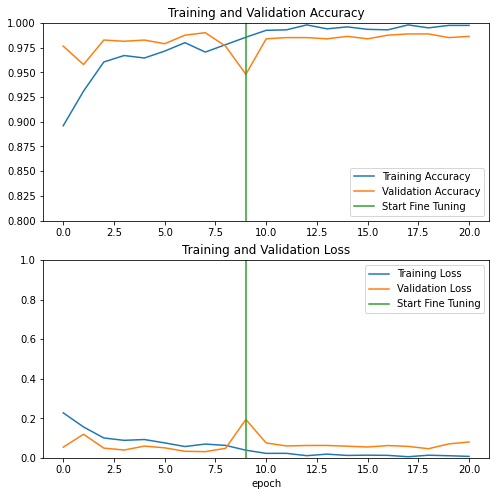

In [50]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initialEpochs-1,initialEpochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initialEpochs-1,initialEpochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

At the 8th epoch of the first training, our model starts overfitting, as the validation accuracy decreases and the validation loss increases. At the fine tuning stage, the model fixes overfitting and reaches nearly 98% accuracy on the validation set.

<h2>Evaluation and Inference</h2>

In [52]:
loss, accuracy = model.evaluate(testDataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 4s 633ms/step - loss: 0.0860 - accuracy: 0.9844
Test accuracy : 0.984375


Predictions:
 [1 0 0 1 0 0 1 1 1 1 1 0 1 0 0 1 0 1 0 0 1 1 1 0 0 1 0 1 1 1 1 1]
Labels:
 [1 0 0 1 0 0 1 1 1 1 1 0 1 0 0 1 0 0 0 0 1 1 1 0 0 1 0 1 1 1 1 1]


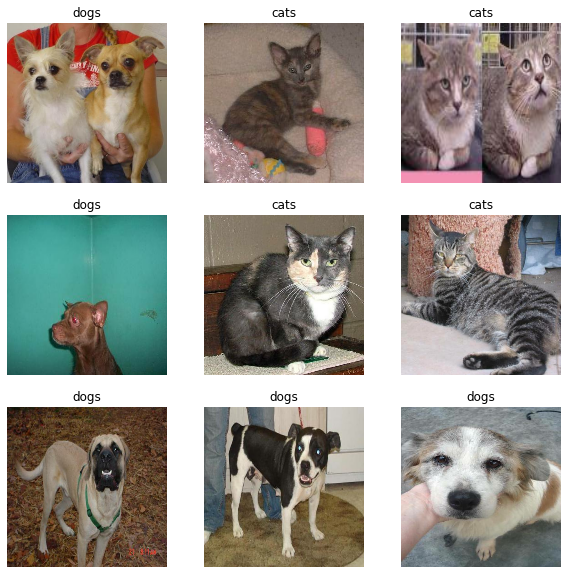

In [62]:
#Retrieve a batch of images from the test set
imageBatch, labelBatch = testDataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(imageBatch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', labelBatch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(imageBatch[i].astype("uint8"))
  plt.title(classNames[predictions[i]])
  plt.axis("off")

<b>Summary</b>

Using a pre-trained model for feature extraction: When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training. In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

Fine-tuning a pre-trained model: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning. In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.